In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [2]:
dataset_path = "D:/archive/animals/animals"

if not os.path.exists(dataset_path):
    print(f"Directory {dataset_path} does not exist")


for label in ['dogs', 'cats', 'panda']:
    class_dir = os.path.join(dataset_path, label)
    if not os.path.exists(class_dir):
        print(f"Directory {class_dir} does not exist")
    else:
        print(f"Directory {class_dir} exists and contains {len(os.listdir(class_dir))} files")


Directory D:/archive/animals/animals\dogs exists and contains 1000 files
Directory D:/archive/animals/animals\cats exists and contains 1000 files
Directory D:/archive/animals/animals\panda exists and contains 1000 files


In [3]:
def load_and_preprocess_images(dataset_path):
    image_size = (32, 32)
    images = []
    labels = []
    classes = ['dogs', 'cats', 'panda']  
    
    for label in classes:
        class_dir = os.path.join(dataset_path, label)
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
            if img is not None:
                img = cv2.resize(img, image_size)  
                images.append(img)
                labels.append(classes.index(label))
    
    images = np.array(images)
    labels = np.array(labels)
    images = images.reshape((images.shape[0], -1))  
    
    return images, labels


X, y = load_and_preprocess_images(dataset_path)

print("Dataset loaded successfully")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Dataset loaded successfully
Shape of X: (3000, 1024)
Shape of y: (3000,)


In [4]:

def evaluate_knn(X, y, k_values, metric, num_folds_list):
    results = {}
    all_predictions = {}
    overall_accuracy = 0
    total_entries = 0
    
    for num_folds in num_folds_list:
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        accuracy_scores = {k: [] for k in k_values}
        predictions = {k: [] for k in k_values}
        
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_val)
                accuracy = accuracy_score(y_val, y_pred)
                accuracy_scores[k].append(accuracy)
                predictions[k].extend(list(zip(y_val, y_pred)))
        
        
        average_accuracies = {k: np.mean(scores) for k, scores in accuracy_scores.items()}
        
        
        for k, avg_acc in average_accuracies.items():
            overall_accuracy += avg_acc
            total_entries += 1
        
        results[num_folds] = average_accuracies
        all_predictions[num_folds] = predictions
    
    
    overall_average_accuracy = overall_accuracy / total_entries
    return results, all_predictions, overall_average_accuracy

k_values = range(1, 21)
num_folds_list = [5]


manhattan_results, manhattan_predictions, manhattan_avg_acc = evaluate_knn(X, y, k_values, 'manhattan', num_folds_list)
euclidean_results, euclidean_predictions, euclidean_avg_acc = evaluate_knn(X, y, k_values, 'euclidean', num_folds_list)


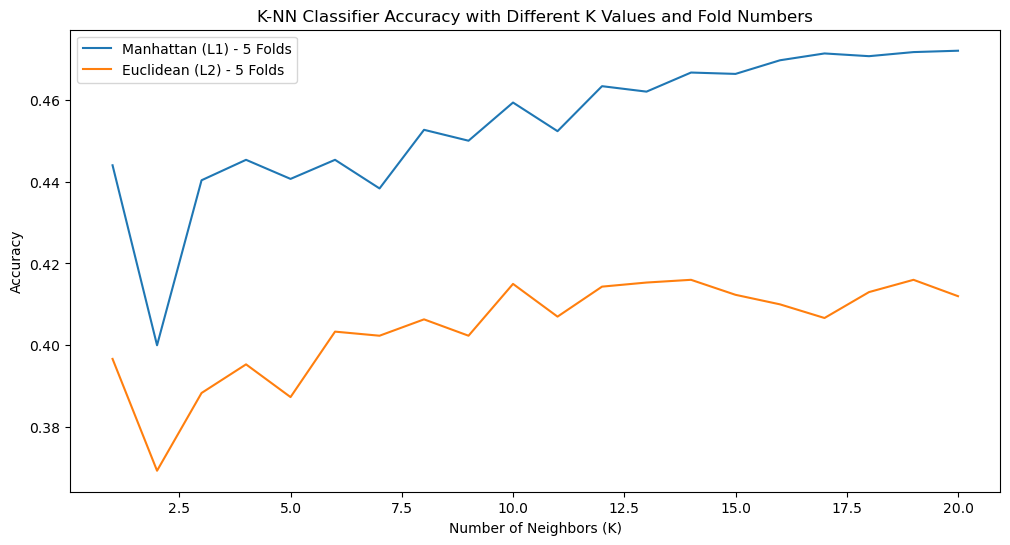

In [5]:
plt.figure(figsize=(12, 6))
for num_folds in num_folds_list:
    plt.plot(list(manhattan_results[num_folds].keys()), list(manhattan_results[num_folds].values()), label=f'Manhattan (L1) - {num_folds} Folds')
    plt.plot(list(euclidean_results[num_folds].keys()), list(euclidean_results[num_folds].values()), label=f'Euclidean (L2) - {num_folds} Folds')

plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Classifier Accuracy with Different K Values and Fold Numbers')
plt.legend()
plt.show()


Best Metric: Manhattan with Average Accuracy: 0.4541


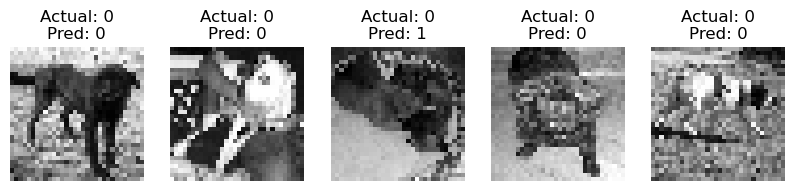

In [6]:

if manhattan_avg_acc > euclidean_avg_acc:
    best_metric = 'manhattan'
    best_predictions = manhattan_predictions
    print(f"Best Metric: Manhattan with Average Accuracy: {manhattan_avg_acc:.4f}")
else:
    best_metric = 'euclidean'
    best_predictions = euclidean_predictions
    print(f"Best Metric: Euclidean with Average Accuracy: {euclidean_avg_acc:.4f}")


k = 5
top_5_predictions = best_predictions[5][k][:5]


original_images = X.reshape((-1, 32, 32))

plt.figure(figsize=(10, 5))

for i, (true_label, predicted_label) in enumerate(top_5_predictions):
    plt.subplot(1, 5, i+1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title(f"Actual: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.show()

In [7]:
#Description
#This code is designed to classify grayscale images of animals using the K-Nearest Neighbors (K-NN) algorithm, with a focus on comparing the performance of different distance metrics. 
#It starts by importing various libraries: NumPy and Pandas for handling arrays and data structures, Matplotlib for plotting, and OpenCV (`cv2`) for image processing tasks like reading and resizing images. 
#The `os` module is used to check the existence of directories and files within the dataset. 
#The Scikit-learn library provides tools such as `KFold` for implementing 5-fold cross-validation, which is a technique to split the dataset into five parts to train and validate the model in multiple rounds, ensuring a more robust evaluation of its performance. 
#The `KNeighborsClassifier` from Scikit-learn is the core machine learning algorithm used to classify images by finding the k-nearest neighbors among the training samples based on distance metrics. 
#The code defines functions to load, preprocess, and flatten the images, followed by evaluating the K-NN classifier's accuracy across different values of k (number of neighbors) and fold numbers. 
#It then visualizes these accuracies to identify the best-performing metric and k value. Finally, it retrieves and displays the top 5 predictions made by the K-NN model using the best metric, alongside the corresponding original images. 
#This entire process allows for a thorough comparison between the Manhattan and Euclidean metrics, demonstrating how different choices of k and distance measures impact the classifier's accuracy.